# Constructing Prediction model
- Selecting models which are the most appropriate
- Constructing the model 
- Confirming model assumptions
- Evaluating model results to determine how well a model fits the data


My goal is to predict whether an employee leaves the company, which is a categorical outcome variable. So this task involves classification. More specifically, this involves binary classification, since the outcome variable `left` can be either 1 (indicating employee left) or 0 (indicating employee didn't leave). So I will build a Logistic Regression model some Tree-based Machine Learning models like Decision Tree, Random Forest anf XGBoost. Compare them against each other to find the best performing model.

### Importing packages

In [21]:
 # For data manipulation
import numpy as np
import pandas as pd

# For data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# For displaying all of the columns in dataframes
pd.set_option('display.max_columns', None)

# For data modeling
from xgboost import XGBClassifier
from xgboost import XGBRegressor
from xgboost import plot_importance

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# For metrics and helpful functions
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score,\
f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.tree import plot_tree

# For saving models
import joblib

In [22]:
# Importing custom functions from utils file that I created for this project
from utils import explore_outlier
from utils import remove_outlier
from utils import make_results
from utils import get_scores
from utils import stratified_split_no_data_leakage   
from utils import plot_classification_matrix

### Loading the dataset

In [23]:
# Loading dataset into a dataframe
df1 = pd.read_csv("hr_dataset_2.csv")

# first few rows of the dataframe
df1.head()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,tenure,work_accident,left,promotion_last_5years,department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


# **Logistic Regression Model**

## 🔎 Model assumptions

**Logistic Regression model assumptions**
- Outcome variable is categorical
- Observations are independent of each other
- No severe multicollinearity among X variables 
- No extreme outliers
- Linear relationship between each X variable and the logit of the outcome variable
- Sufficiently large sample size 





### Converting categorical columns to numerical/boolean columns

Before splitting the data, I will encode the non-numeric variables. There are two: `department` and `salary`. 

`department` is a categorical variable, which means I can dummy it for modeling. 

`salary` is categorical too, but it's ordinal. There's a hierarchy to the categories, so it's better not to dummy this column, but rather to convert the levels to numbers, 0-2.

In [24]:
# Copy the dataframe
df_enc = df1.copy()

# Encode the `salary` column as an ordinal numeric category
df_enc['salary'] = (
    df_enc['salary'].astype('category')
    .cat.set_categories(['low', 'medium', 'high'])
    .cat.codes
)

# Dummy encode the `department` column
df_enc = pd.get_dummies(df_enc, drop_first=False)

# Display the new dataframe
df_enc.head()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,tenure,work_accident,left,promotion_last_5years,salary,department_IT,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical
0,0.38,0.53,2,157,3,0,1,0,0,False,False,False,False,False,False,False,True,False,False
1,0.80,0.86,5,262,6,0,1,0,1,False,False,False,False,False,False,False,True,False,False
2,0.11,0.88,7,272,4,0,1,0,1,False,False,False,False,False,False,False,True,False,False
3,0.72,0.87,5,223,5,0,1,0,0,False,False,False,False,False,False,False,True,False,False
4,0.37,0.52,2,159,3,0,1,0,0,False,False,False,False,False,False,False,True,False,False


Creating a heatmap to visualize how correlated variables are. Considering the variables I am interested in examining correlations between.

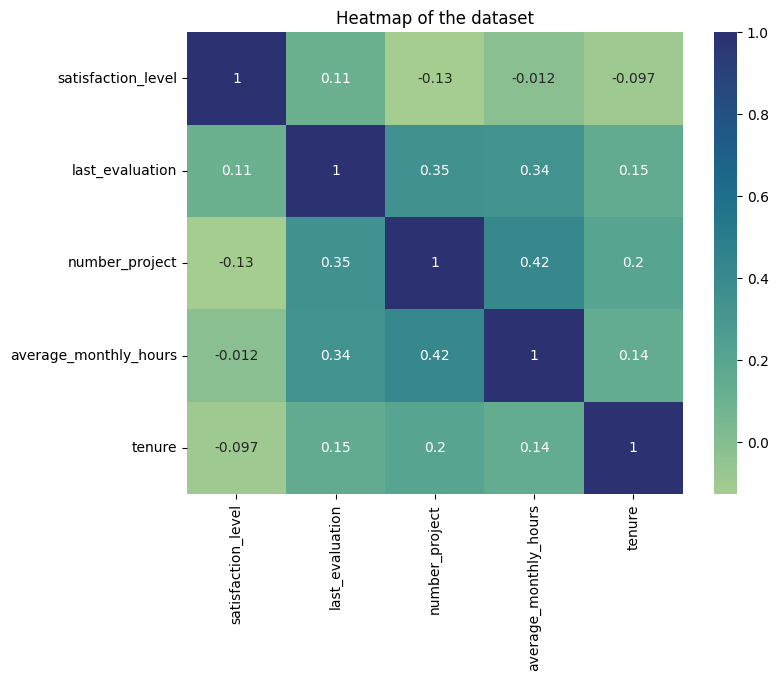

In [25]:
# Heatmap to visualize how correlated variables are
plt.figure(figsize=(8, 6))
sns.heatmap(df_enc[['satisfaction_level', 'last_evaluation', 'number_project', 'average_monthly_hours', 'tenure']]
            .corr(), annot=True, cmap="crest")
plt.title('Heatmap of the dataset')
plt.show()

Stacked bar plot to visualize number of employees across department, comparing those who left with those who didn't.

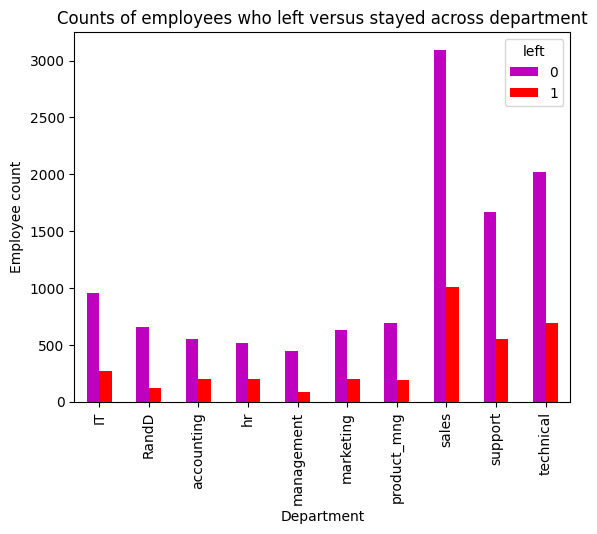

In [26]:
# In the legend, 
# 0 (purple color) represents employees who did not leave
# 1 (red color) represents employees who left
pd.crosstab(df1['department'], df1['left']).plot(kind ='bar',color='mr')
plt.title('Counts of employees who left versus stayed across department')
plt.ylabel('Employee count')
plt.xlabel('Department')
plt.show()

Since logistic regression is quite sensitive to outliers, it would be a good idea at this stage to remove the outliers in the `tenure` column that were identified earlier.

In [27]:
# Using the function from utils.py to remove outliers in `tenure` column
df_logreg = remove_outlier(df_enc, 'tenure')
df_logreg.head()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,tenure,work_accident,left,promotion_last_5years,salary,department_IT,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical
0,0.38,0.53,2,157,3,0,1,0,0,False,False,False,False,False,False,False,True,False,False
2,0.11,0.88,7,272,4,0,1,0,1,False,False,False,False,False,False,False,True,False,False
3,0.72,0.87,5,223,5,0,1,0,0,False,False,False,False,False,False,False,True,False,False
4,0.37,0.52,2,159,3,0,1,0,0,False,False,False,False,False,False,False,True,False,False
5,0.41,0.50,2,153,3,0,1,0,0,False,False,False,False,False,False,False,True,False,False


Isolating the outcome variable, which is the variable I want the model to predict.

In [28]:
# Isolating the outcome variable
y = df_logreg['left']

# First few rows of the outcome variable
y.head() 

0    1
2    1
3    1
4    1
5    1
Name: left, dtype: int64

Selecting the features which will help the model to predict the outcome variable `left`.

In [29]:
# Selecting helpful features 
X = df_logreg.drop('left', axis=1)

# First few rows of the selected features 
X.head()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,tenure,work_accident,promotion_last_5years,salary,department_IT,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical
0,0.38,0.53,2,157,3,0,0,0,False,False,False,False,False,False,False,True,False,False
2,0.11,0.88,7,272,4,0,0,1,False,False,False,False,False,False,False,True,False,False
3,0.72,0.87,5,223,5,0,0,0,False,False,False,False,False,False,False,True,False,False
4,0.37,0.52,2,159,3,0,0,0,False,False,False,False,False,False,False,True,False,False
5,0.41,0.50,2,153,3,0,0,0,False,False,False,False,False,False,False,True,False,False


Spliting the data into training set and testing set. Stratifying based on the values in `y`, since the classes are unbalanced.

In [30]:
# Spliting the data into training set and testing set
X_train, X_test, y_train, y_test = stratified_split_no_data_leakage(df_logreg, target_col='left')

Constructing and fitting a logistic regression model.

In [31]:
log_clf = LogisticRegression(random_state=42, max_iter=1000).fit(X_train, y_train)

Testing the logistic regression model on the test set.

In [32]:
y_pred = log_clf.predict(X_test)

Confusion matrix to visualize the results of the logistic regression model. 

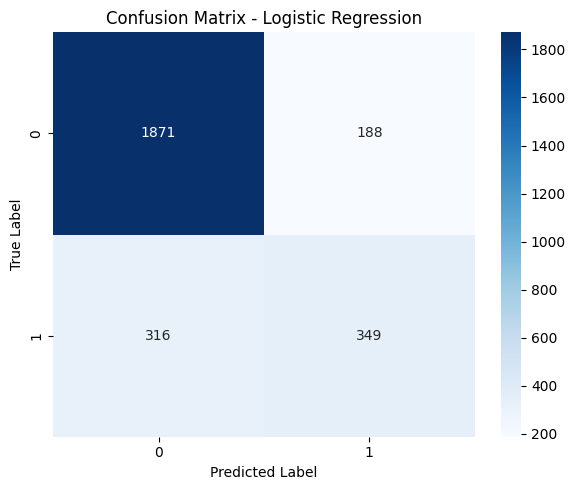

In [33]:
# Display the classification matrix
plot_classification_matrix(log_clf, X_test, y_test, model_name='Logistic Regression')

- The upper-left quadrant displays the number of true negatives.
- The upper-right quadrant displays the number of false positives.
- The bottom-left quadrant displays the number of false negatives.
- The bottom-right quadrant displays the number of true positives.

True negatives: The number of people who did not leave that the model accurately predicted did not leave.

False positives: The number of people who did not leave the model inaccurately predicted as leaving.

False negatives: The number of people who left that the model inaccurately predicted did not leave

True positives: The number of people who left the model accurately predicted as leaving

A perfect model would yield all true negatives and true positives, and no false negatives or false positives.

Creating a classification report that includes precision, recall, f1-score, and accuracy metrics to evaluate the performance of the logistic regression model.

Checking the class balance in the data. In other words, checking the value counts in the `left` column. Since this is a binary classification task, the class balance informs the way you interpret accuracy metrics.

In [34]:
df_logreg['left'].value_counts(normalize=True)

left
0    0.757053
1    0.242947
Name: proportion, dtype: float64

There is an approximately 76%-24% split. So the data is not perfectly balanced, but it is not too imbalanced. In this case, I can use this data without modifying the class balance and continue evaluating the model.

In [35]:
# Creating classification report for logistic regression model
target_names = ['Predicted would not leave', 'Predicted would leave']
print(classification_report(y_test, y_pred, target_names=target_names))

                           precision    recall  f1-score   support

Predicted would not leave       0.86      0.91      0.88      2059
    Predicted would leave       0.65      0.52      0.58       665

                 accuracy                           0.81      2724
                macro avg       0.75      0.72      0.73      2724
             weighted avg       0.81      0.81      0.81      2724



The classification report above shows that the logistic regression model achieved a precision of 86%, recall of 91%, f1-score of 88% (all weighted averages), and accuracy of 81%. However, if it's most important to predict employees who leave, then the scores are significantly lower.

### **Tree-based Model**
Decision Tree, Random Forest and XGBoost. 

#### **Decision tree** 

Constructing a decision tree model and setting-up cross-validated grid-search to exhuastively search for the best model parameters.

In [36]:
# Splitting the data into training set and testing set
X_train, X_test, y_train, y_test = stratified_split_no_data_leakage(df_enc, target_col='left')

In [37]:
# Instantiating model
tree = DecisionTreeClassifier(random_state=0)

# Assigning a dictionary of hyperparameters to search over
cv_params = {'max_depth':[4, 6, 8, None],
             'min_samples_leaf': [2, 5, 1],
             'min_samples_split': [2, 4, 6]
             }

# Assigning a dictionary of scoring metrics to capture
scoring = {'accuracy': 'accuracy',
           'precision': 'precision',
           'recall': 'recall',
           'f1': 'f1',
           'roc_auc': 'roc_auc'}

# Instantiating GridSearch
tree1 = GridSearchCV(tree, cv_params, scoring=scoring, cv=4, refit='roc_auc')

Fitting the decision tree model to the training data.

In [38]:
%%time
# Fitting the model to the training data
tree1 = tree1.fit(X_train, y_train)
best_tree_model1 = tree1.best_estimator_

# Saving the model to a file
joblib.dump(best_tree_model1 , 'tree1_model.pkl')

CPU times: total: 7.17 s
Wall time: 7.35 s


['tree1_model.pkl']

Identifying optimal values for the decision tree parameters.

In [39]:
# Loading the model from a file
tree1 = joblib.load('tree_model.pkl')

# Best parameters
tree1.best_params_

{'max_depth': None, 'min_samples_leaf': 5, 'min_samples_split': 2}

In [40]:
# Best AUC score on CV
tree1.best_score_

np.float64(0.9798688655919681)

This is a strong AUC score, which shows that this model can predict employees who will leave very well. 

Using the function 'make_results' fram utils.py file to get all the scores from grid search.

In [41]:
# Get all CV scores
tree1_cv_results = make_results('decision tree cv', tree1, 'auc')
tree1_cv_results

,model,precision,recall,F1,accuracy,auc
0,decision tree cv,0.957514,0.931452,0.944134,0.973259,0.979869


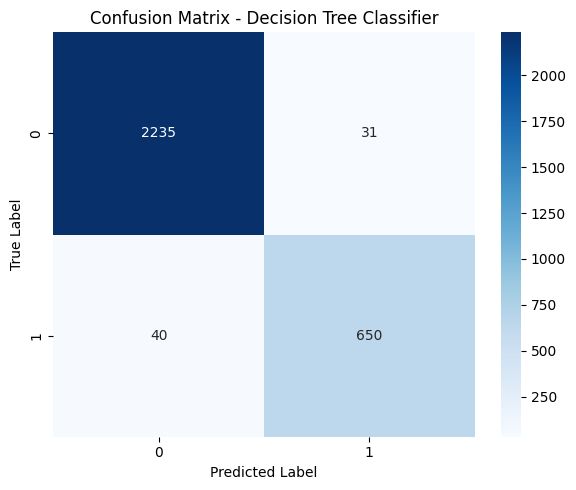

In [42]:
# Display the confusion_matrix
plot_classification_matrix(tree1, X_test, y_test, model_name='Decision Tree Classifier')

All of these scores from the decision tree model are strong indicators of good model performance. 

Recall that decision trees can be vulnerable to overfitting, and random forests avoid overfitting by incorporating multiple trees to make predictions. Next I will construct a random forest model.

#### Random forest - Round 1

Constructing a random forest model, cross-validating with grid-search to exhuastively search for the best model parameters.

In [ ]:
# Splitting the data into training set and testing set
X_train, X_test, y_train, y_test = stratified_split_no_data_leakage(df_enc, target_col='left')

In [54]:
# Instantiating model
rf = RandomForestClassifier(random_state=0)

# Assigning a dictionary of hyperparameters to search over
cv_params = {'max_depth': [3,5, None], 
             'max_features': [1.0],
             'max_samples': [0.7, 1.0],
             'min_samples_leaf': [1,2,3],
             'min_samples_split': [2,3,4],
             'n_estimators': [300, 500],
             }  

# Assigning a dictionary of scoring metrics to capture
scoring = {'accuracy': 'accuracy',
           'precision': 'precision',
           'recall': 'recall',
           'f1': 'f1',
           'roc_auc': 'roc_auc'}

# Instantiating GridSearch
rf1 = GridSearchCV(rf, cv_params, scoring=scoring, cv=4, refit='roc_auc')

Fitting the random forest model to the training data.

In [ ]:
%%time
rf1.fit(X_train, y_train)
best_rf_model1 = rf1.best_estimator_

CPU times: total: 0 ns
Wall time: 0 ns


Saving the random forest gridsearchCV model

In [ ]:
joblib.dump(best_rf_model1 , 'rf1_model.pkl')

Loading the random forest gridsearchCV model

In [57]:
rf1 = joblib.load('rf1_model.pkl')

Best AUC score achieved by the random forest model on the training set.

In [58]:
# Best AUC score on CV
rf1.best_score_

np.float64(0.9910502446609449)

Optimal values for the parameters of the random forest model.

In [59]:
# Best parammeters on CV
rf1.best_params_

{'max_depth': None,
 'max_features': 1.0,
 'max_samples': 0.7,
 'min_samples_leaf': 3,
 'min_samples_split': 2,
 'n_estimators': 500}

Confusion matrix

In [ ]:
# Display the confusion_matrix
plot_classification_matrix(rf1, X_test, y_test, model_name='Random forest Classifier')

### **XGBoost Model**

Constructing a XGBoost model and setting-up cross-validated grid-search to exhuastively search for the best model parameters.

In [20]:
# Splitting the data into training set and testing set
X_train, X_test, y_train, y_test = stratified_split_no_data_leakage(df_enc, target_col='left')

In [21]:
# Instantiating model
xgb = XGBClassifier(random_state=0)

# Assigning a dictionary of hyperparameters to search over
cv_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 1, 5],
    'reg_alpha': [0, 0.01, 0.1, 1],
    'reg_lambda': [0.1, 1, 10],
}


# Assigning a dictionary of scoring metrics to capture
scoring = {'accuracy': 'accuracy',
           'precision': 'precision',
           'recall': 'recall',
           'f1': 'f1',
           'roc_auc': 'roc_auc'}

# Instantiating GridSearch
xgb1 = GridSearchCV(xgb, cv_params, scoring=scoring, cv=4, refit='roc_auc')

Fitting the XGBoost model to the training data, then saving the best model

In [ ]:
%%time
# Fitting the model to the training data
xgb1 = xgb1.fit(X_train, y_train)
best_xgb_model1 = xgb1.best_estimator_

# Saving the model to a file    
joblib.dump(best_xgb_model1 , 'xgb1_model.pkl')

Loading the model trained on best parameters

In [ ]:
# Loading the model from a file
xgb1 = joblib.load('xgb1_model.pkl')

Best AUC score accieved by the XGBoost model on training set

In [ ]:
# Best AUC score on CV
xgb1.best_score_

Optimal values for the parameters of the XGBoost model 

In [ ]:
# Checking the best parameters 
xgb1.best_params_

Predicting and evaluating the XGBoost model on testing set

In [ ]:
y_pred = xgb1.predict(X_test)

# Computing values for confusion matrix
xgb_cm = confusion_matrix(y_test, y_pred, labels=xgb1.classes_)


The test scores are very similar to the validation scores, which is good. This appears to be a strong model. Since this test set was only used for this model, I can be confident that my model's performance on this data is representative of how it will perform on new, unseeen data.

Collecting the evaluation scores on the training set for the decision tree, random forest models and XGBoost model

In [ ]:
# All CV scores
rf1_cv_results = make_results('random forest cv', rf1, 'auc')
xgb1_cv_results = make_results('xgboost cv', xgb1, 'auc')
print(tree1_cv_results)
print(rf1_cv_results)
print(xgb1_cv_results)

#### Feature Engineering

I am slightly skeptical of the high evaluation scores. There is a chance that there is some data leakage occurring. Data leakage is when you use data to train your model that should not be used during training, either because it appears in the test data or because it's not data that you'd expect to have when the model is actually deployed. Training a model with leaked data can give an unrealistic score that is not replicated in production.

In this case, it's likely that the company won't have satisfaction levels reported for all of its employees. It's also possible that the `average_monthly_hours` column is a source of some data leakage. If employees have already decided upon quitting, or have already been identified by management as people to be fired, they may be working fewer hours. 

The first round of decision tree and random forest models included all variables as features. In the next round I will incorporate feature engineering to build improved models. 

First I will drop `satisfaction_level` and create a new feature that roughly captures whether an employee is overworked. I will call this new feature `overworked`. It will be a binary variable.

In [62]:
# Drop `satisfaction_level` and save resulting dataframe in new variable
df2 = df_enc.drop('satisfaction_level', axis=1)

# Display first few rows of new dataframe
df2.head()

,last_evaluation,number_project,average_monthly_hours,tenure,work_accident,left,promotion_last_5years,salary,department_IT,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical
0,0.53,2,157,3,0,1,0,0,False,False,False,False,False,False,False,True,False,False
1,0.86,5,262,6,0,1,0,1,False,False,False,False,False,False,False,True,False,False
2,0.88,7,272,4,0,1,0,1,False,False,False,False,False,False,False,True,False,False
3,0.87,5,223,5,0,1,0,0,False,False,False,False,False,False,False,True,False,False
4,0.52,2,159,3,0,1,0,0,False,False,False,False,False,False,False,True,False,False


In [63]:
# Creating `overworked` column. For now, it's identical to average monthly hours.
df2['overworked'] = df2['average_monthly_hours']

# max and min average monthly hours values
print('Max hours:', df2['overworked'].max())
print('Min hours:', df2['overworked'].min())

Max hours: 310
Min hours: 96


166.67 is approximately the average number of monthly hours for someone who works 50 weeks per year, 5 days per week, 8 hours per day. 

Being overworked is working more than 175 hours per month on average.

To make the `overworked` column binary, I will reassign the column using a boolean mask.
- `df2['overworked'] > 175` creates a series of booleans, consisting of `True` for every value > 175 and `False` for every values ≤ 175
- `.astype(int)` converts all `True` to `1` and all `False` to `0` 

In [64]:
# Defining `overworked` as working > 175 hrs/week
df2['overworked'] = (df2['overworked'] > 175).astype(int)

# Display first few rows of new column
df2['overworked'].head()

0    0
1    1
2    1
3    1
4    0
Name: overworked, dtype: int64

In [65]:
# Dropping the `average_monthly_hours` column
df2 = df2.drop('average_monthly_hours', axis=1)

df2.head()

,last_evaluation,number_project,tenure,work_accident,left,promotion_last_5years,salary,department_IT,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical,overworked
0,0.53,2,3,0,1,0,0,False,False,False,False,False,False,False,True,False,False,0
1,0.86,5,6,0,1,0,1,False,False,False,False,False,False,False,True,False,False,1
2,0.88,7,4,0,1,0,1,False,False,False,False,False,False,False,True,False,False,1
3,0.87,5,5,0,1,0,0,False,False,False,False,False,False,False,True,False,False,1
4,0.52,2,3,0,1,0,0,False,False,False,False,False,False,False,True,False,False,0


Split the data into training and testing sets.

In [ ]:
X_train, X_test, y_train, y_test = stratified_split_no_data_leakage(df2, target_col='left')

NameError: name 'df2' is not defined

#### Decision tree - Round 2

In [68]:
# Instantiating Decision tree model
dtc = DecisionTreeClassifier(random_state=0)

# Dictionary of hyperparameters to search over
cv_params = {'max_depth':[4, 6, 8, None],
             'min_samples_leaf': [2, 5, 1],
             'min_samples_split': [2, 4, 6]
             }

# Dictionary of scoring metrics to capture
scoring = {'accuracy' : 'accuracy',
            'f1' : 'f1',
            'precision' : 'precision',
            'recall' : 'recall',
            'roc_auc' : 'roc_auc'}

# Instantiating GridSearch
tree2 = GridSearchCV(dtc, cv_params, scoring=scoring, cv=4, refit='roc_auc')

In [ ]:
%%time
tree2.fit(X_train, y_train)
best_tree_model2 = tree2.best_estimator_

# Saving the model to a file
joblib.dump(best_tree_model2, 'tree2_model.pkl')

CPU times: total: 8.64 s
Wall time: 8.63 s


['tree2_model.pkl']

In [70]:
# Best parameters on CV
tree2.best_params_

{'max_depth': None, 'min_samples_leaf': 5, 'min_samples_split': 2}

In [71]:
# Best AUC score on CV
tree2.best_score_

np.float64(0.970911442444901)

This model performs very well, even without satisfaction levels and detailed hours worked data. 

Next, checking other scores.

In [72]:
# All CV scores
tree2_cv_results = make_results('decision tree2 cv', tree2, 'auc')
print(tree1_cv_results)
print(tree2_cv_results)

              model  precision    recall        F1  accuracy       auc
0  decision tree cv   0.957514  0.931452  0.944134  0.973259  0.979869
               model  precision    recall        F1  accuracy       auc
0  decision tree2 cv   0.912618  0.891162  0.901761  0.953661  0.970911


Some of the other scores fell. That's to be expected given fewer features were taken into account in this round of the model. Still, the scores are very good.

#### Random forest - Round 2

In [73]:
# Instantiating model
rf = RandomForestClassifier(random_state=0)

# Dictionary of hyperparameters to search over
cv_params = {'max_depth': [3,5, None], 
             'max_features': [1.0],
             'max_samples': [0.7, 1.0],
             'min_samples_leaf': [1,2,3],
             'min_samples_split': [2,3,4],
             'n_estimators': [300, 500],
             }  

# Dictionary of scoring metrics to capture
scoring = {'accuracy' : 'accuracy',
            'f1' : 'f1',
            'precision' : 'precision',
            'recall' : 'recall',
            'roc_auc' : 'roc_auc'}

# Instantiating GridSearch
rf2 = GridSearchCV(rf, cv_params, scoring=scoring, cv=4, refit='roc_auc')

In [ ]:
%%time
rf2.fit(X_train, y_train) 
best_rf_model2 = rf2.best_estimator_

# Saving the model to a file
joblib.dump(best_rf_model2, 'rf2_model.pkl')

KeyboardInterrupt: 

In [ ]:
# Loading the model from a file
rf2 = joblib.load('rf2_model.pkl')

In [ ]:
# Best parameters on CV
rf2.best_params_

{'max_depth': None,
 'max_features': 1.0,
 'max_samples': 0.7,
 'min_samples_leaf': 1,
 'min_samples_split': 4,
 'n_estimators': 500}

In [ ]:
# Best AUC score on CV
rf2.best_score_

np.float64(0.9805780157618604)

In [ ]:
# All CV scores
rf2_cv_results = make_results('random forest2 cv', rf2, 'auc')
print(tree2_cv_results)
print(rf2_cv_results)

               model  precision    recall        F1  accuracy       auc
0  decision tree2 cv   0.912618  0.891162  0.901761  0.953661  0.970911
               model  precision    recall        F1  accuracy       auc
0  random forest2 cv   0.935323  0.921501  0.928324   0.96606  0.980578


Again, the scores dropped slightly, but the random forest performs better than the decision tree. 

So Random Forest is the champion model here.

In [ ]:
# Scoring the champion model on the test set now.
rf2_test_scores = get_scores('random forest2 test', rf2, X_test, y_test)
rf2_test_scores

,model,precision,recall,f1,accuracy,AUC
0,random forest2 test,0.92395,0.926052,0.925,0.96416,0.951079


This seems to be a stable, well-performing final model. 

Plotting a confusion matrix to visualize how well it predicts on the test set.

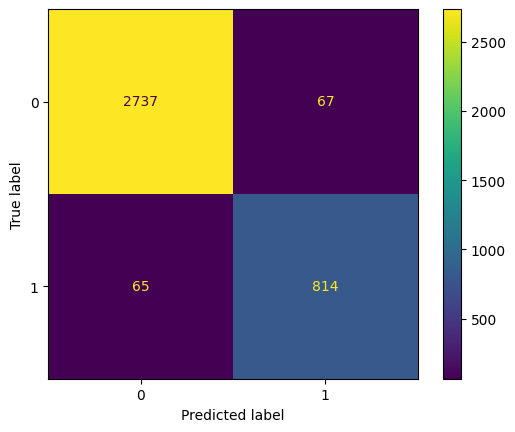

In [ ]:
# Array of values for confusion matrix
preds = rf2.best_estimator_.predict(X_test)
cm = confusion_matrix(y_test, preds, labels=rf2.classes_)

# Confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=rf2.classes_)
disp.plot(values_format='');

The model predicts more false positives than false negatives, which means that some employees may be identified as at risk of quitting or getting fired, when that's actually not the case. But this is still a strong model.

For exploratory purpose, I will inspect the splits of the decision tree model and the most important features in the random forest model. 

#### Decision tree splits

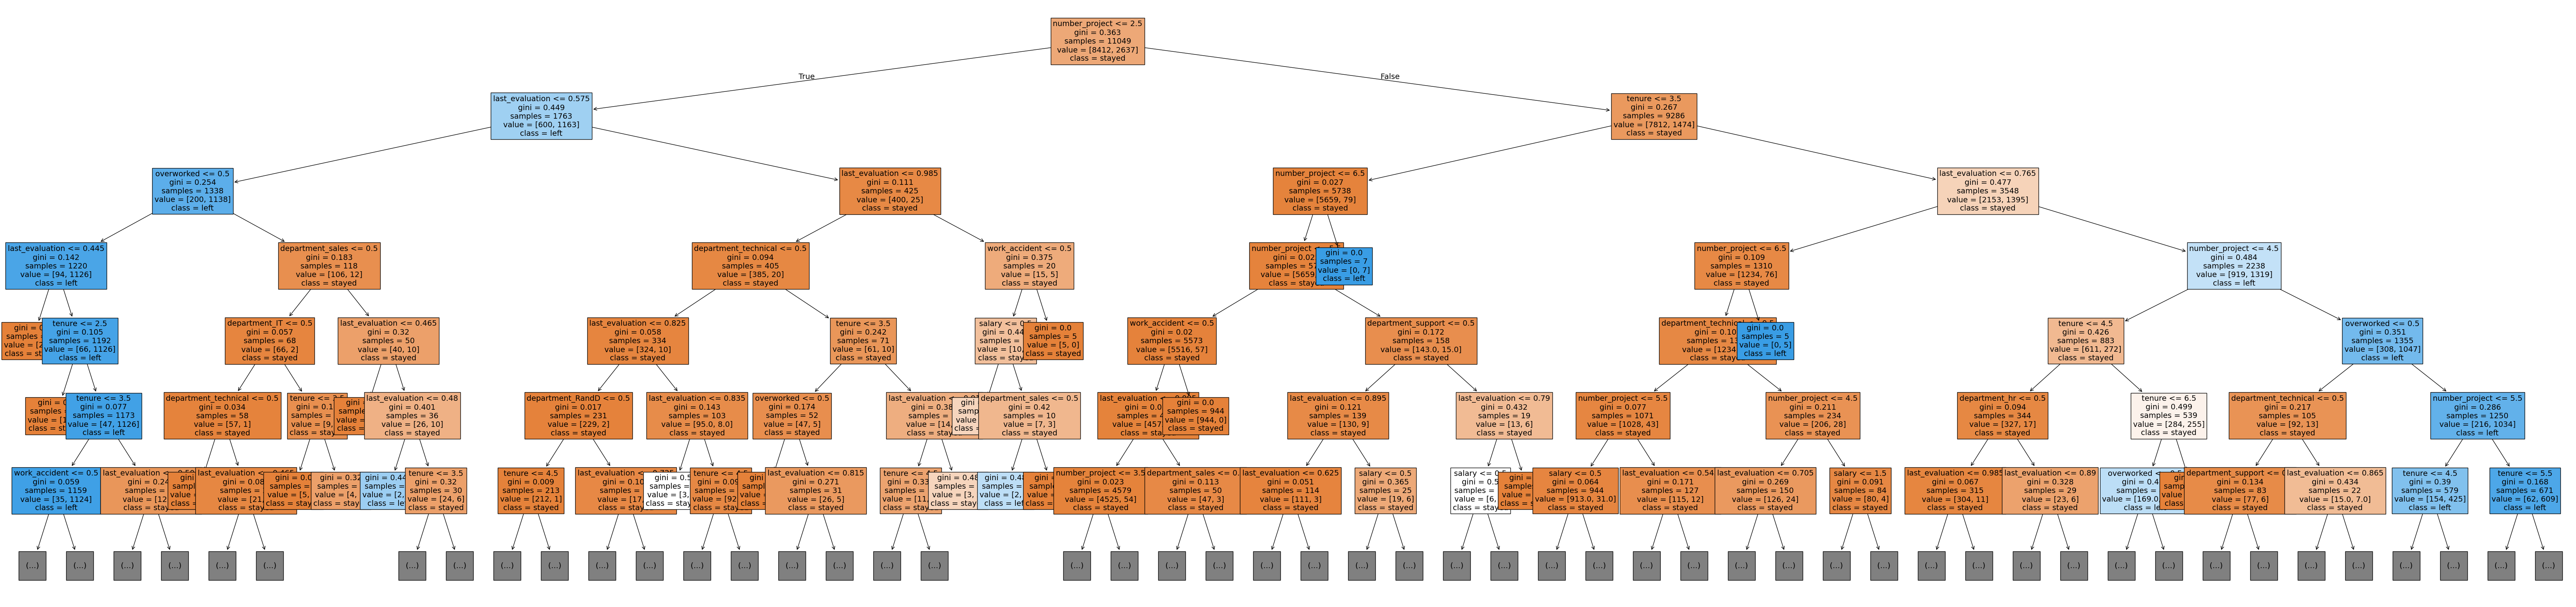

In [ ]:
# Plotting the decision tree splits
plt.figure(figsize=(85,20))
plot_tree(tree2.best_estimator_, max_depth=6, fontsize=14, feature_names=X.columns, 
          class_names={0:'stayed', 1:'left'}, filled=True);
plt.show()

#### Decision tree feature importance

In [ ]:
tree2_importances = pd.DataFrame(tree2.best_estimator_.feature_importances_, 
                                 columns=['gini_importance'], 
                                 index=X.columns
                                )
tree2_importances = tree2_importances.sort_values(by='gini_importance', ascending=False)

# Only extracting the features with importances > 0
tree2_importances = tree2_importances[tree2_importances['gini_importance'] != 0]
tree2_importances

,gini_importance
last_evaluation,0.310308
number_project,0.303584
tenure,0.273947
overworked,0.083461
salary,0.008446
work_accident,0.004325
department_sales,0.004313
department_technical,0.004176
department_support,0.001864
department_IT,0.001767


Barplot to visualize the decision tree feature importances.

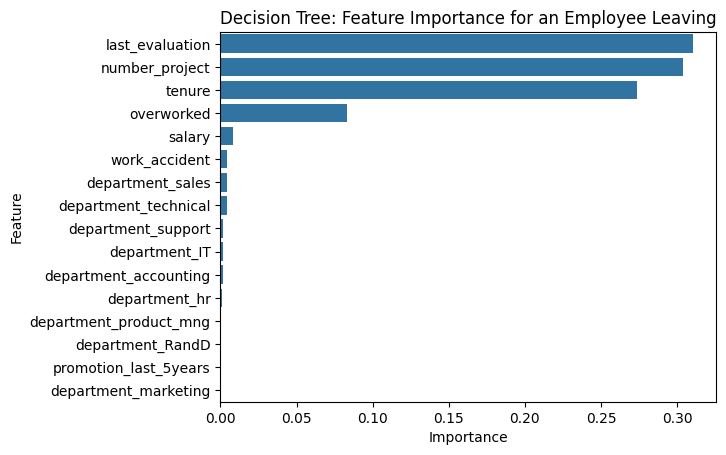

In [ ]:
sns.barplot(data=tree2_importances, x="gini_importance", y=tree2_importances.index, orient='h')
plt.title("Decision Tree: Feature Importance for an Employee Leaving", fontsize=12)
plt.ylabel("Feature")
plt.xlabel("Importance")
plt.show()


The barplot above shows that in this decision tree model, `last_evaluation`, `number_project`, `tenure`, and `overworked` have the highest importance, in that order. These variables are most helpful in predicting the outcome variable, `left`.

#### Random forest feature importance

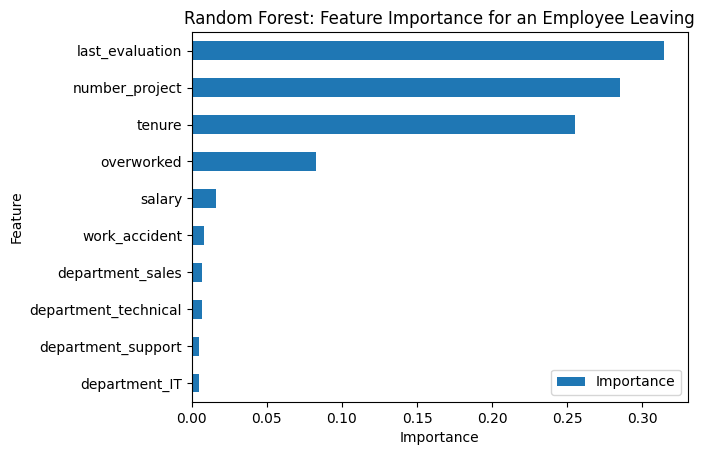

In [ ]:
# Feature importances
feat_imp = rf2.best_estimator_.feature_importances_

# Indices of top 10 features
ind = np.argpartition(rf2.best_estimator_.feature_importances_, -10)[-10:]

# Column labels of top 10 features 
feat = X.columns[ind]

# Filtering `feat_imp` to consist of top 10 feature importances
feat_imp = feat_imp[ind]

y_df = pd.DataFrame({"Feature":feat,"Importance":feat_imp})
y_sort_df = y_df.sort_values("Importance")
fig = plt.figure()
ax1 = fig.add_subplot(111)

y_sort_df.plot(kind='barh',ax=ax1,x="Feature",y="Importance")

ax1.set_title("Random Forest: Feature Importance for an Employee Leaving", fontsize=12)
ax1.set_ylabel("Feature")
ax1.set_xlabel("Importance")

plt.show()

The plot above shows that in this random forest model, `last_evaluation`, `number_project`, `tenure` and `overworked` have the highest importance, in that order. These variables are most helpful in predicting the outcome variable, `left`, and they are the same as the ones used by the decision tree model.

## Evaluation metrics

- **AUC** is the area under the ROC curve; it's also considered the probability that the model ranks a random positive example more highly than a random negative example. 
- **Precision** measures the proportion of data points predicted as True that are actually True, in other words, the proportion of positive predictions that are true positives.
- **Recall** measures the proportion of data points that are predicted as True, out of all the data points that are actually True. In other words, it measures the proportion of positives that are correctly classified.
- **Accuracy** measures the proportion of data points that are correctly classified.
- **F1-score** is an aggregation of precision and recall.






💭 
### Reflect on these questions as you complete the executing stage.

- What key insights emerged from your model(s)?
- What business recommendations do you propose based on the models built?
- What potential recommendations would you make to your manager/company?
- Do you think your model could be improved? Why or why not? How? 
- Given what you know about the data and the models you were using, what other questions could you address for the team? 
- What resources do you find yourself using as you complete this stage? (Make sure to include the links.)
- Do you have any ethical considerations in this stage?



## Results and Evaluation

### Summary of model results

**Logistic Regression**

The logistic regression model achieved precision of 80%, recall of 83%, f1-score of 80% (all weighted averages), and accuracy of 83%, on the test set.

**Tree-based Machine Learning**

After conducting feature engineering, the decision tree model achieved AUC of 93.8%, precision of 87.0%, recall of 90.4%, f1-score of 88.7%, and accuracy of 96.2%, on the test set. The random forest modestly outperformed the decision tree model. 

### Conclusion, Recommendations, Next Steps

The models and the feature importances extracted from the models confirm that employees at the company are overworked. 

To retain employees, the following are some recommendations to the stakeholders:

* Cap the number of projects that employees can work on. `(3-4 projects)`
* Consider `promoting employees` who have been with the company for atleast `four years`, or conduct further investigation about why four-year tenured employees are so dissatisfied. 
* Either `reward employees` for `working longer hours`, or don't require them to do so. 
* If employees aren't familiar with the company's `overtime pay policies`, inform them about this. If the expectations around workload and time off aren't explicit, make them clear. 
* Hold company-wide and within-team discussions to understand and address the company work culture, across the board and in specific contexts. 
* `High evaluation scores` should `not` be reserved for employees who `work 200+ hours per month`. Consider a `proportionate scale` for `rewarding employees` who `contribute` more/put in more effort. 

**Next Steps**

It may be justified to still have some concern about data leakage. It could be prudent to consider how predictions change when `last_evaluation` is removed from the data. It's possible that evaluations aren't performed very frequently, in which case it would be useful to be able to predict employee retention without this feature. It's also possible that the evaluation score determines whether an employee leaves or stays, in which case it could be useful to pivot and try to predict performance score. The same could be said for satisfaction score. 

For another project, you could try building a K-means model on this data and analyzing the clusters. This may yield valuable insight. 